# Training custom CNN models

1. [Custom model, case1](#sec1)
    1a. [Splitting into train, validation, and test datasets](#sec1a)
    1b. [Augmenting the dataset](#sec1b)
    1c. [Training using `train_dataset`](#sec1c)

2. [Custom model, case2](#sec2)
    2a. [Training using `train_dataset`](#sec2a)
    2b. [Validation using `test_dataset`](#sec2b)

In [78]:
import matplotlib.pyplot as plt
import os
import pickle 
import tensorflow as tf
import tensorflow.keras as tfk

import mototaxi_utils as mutils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='sec1'></a>
## 1. Customizing model MobileNetV2: case1

<a id='sec1a'></a>
### 1a. Splitting the data: train, validation, and test datasets


In [147]:
batch_size = 16 
image_size = (224, 224)

img_dir = os.path.join(os.path.expanduser('~'), 'Downloads/dldata/mototaxi_training_images/')
train_dataset = tfk.preprocessing.image_dataset_from_directory(img_dir,
                                                               shuffle=True,
                                                               batch_size=batch_size,
                                                               image_size=image_size,
                                                               validation_split=0.3,
                                                               subset='training',
                                                               seed=40
                                                               )
valtest_dataset = tfk.preprocessing.image_dataset_from_directory(img_dir,
                                                               shuffle=True,
                                                               batch_size=batch_size,
                                                               image_size=image_size,
                                                               validation_split=0.3,
                                                               subset='validation',
                                                               seed=40)

valtest_len = tf.data.experimental.cardinality(valtest_dataset) #42 batches of size 8 -> ~336 pics
val_dataset = valtest_dataset.take((2*valtest_len) // 3)  #take the first 2/3 of batches
test_dataset = valtest_dataset.skip((2*valtest_len) // 3) #take the last 1/3 of the batches
print('\nNumber of batches in each dataset')
print(f'train_dataset: Number of batches={len(train_dataset)}')
print(f'val_dataset: Number of batches={len(val_dataset)}')
print(f'test_dataset: Number of batches={len(test_dataset)}')

print('\nAvailable classes (inferred from directory structure):')
print(train_dataset.class_names)

Found 1116 files belonging to 2 classes.
Using 782 files for training.
Found 1116 files belonging to 2 classes.
Using 334 files for validation.

Number of batches in each dataset
train_dataset: Number of batches=49
val_dataset: Number of batches=14
test_dataset: Number of batches=7

Available classes (inferred from directory structure):
['mototaxi', 'no_mototaxi']


<a id='sec1b'></a>
### 1b. Augmenting the dataset
In order to augment the training data, we produce *new* images by introducing random distortions (flips `RandomFlip` or rotations `RandomRotation`) to the original images. Contrary to Pytorch, Tensorflow has an easy way to add random rotations. Below we show one original image along with 8 distortions; notice that the distortions are calibrated to avoid producing unrealistic images. 

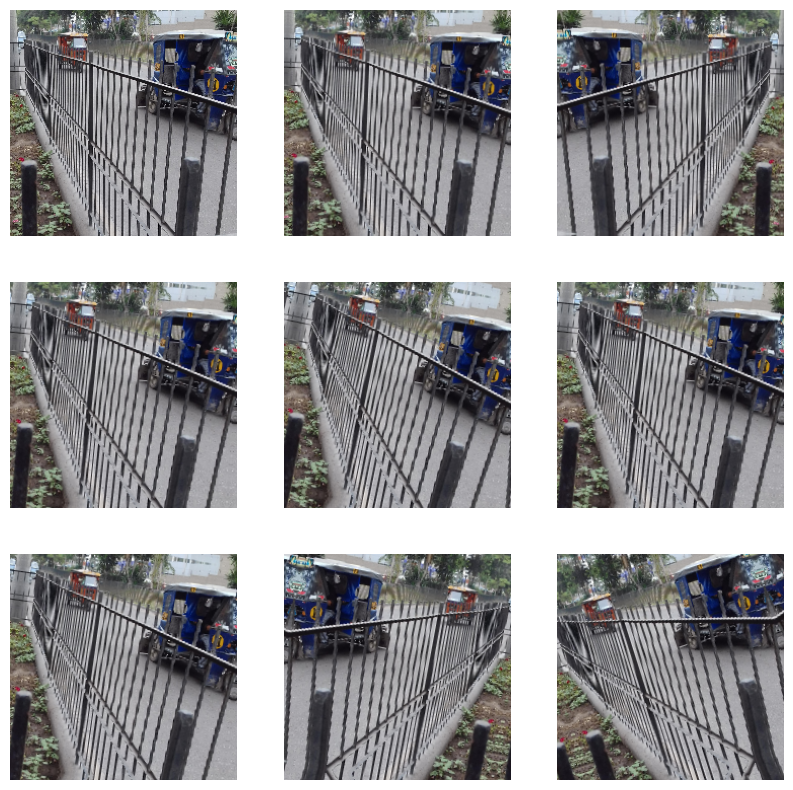

In [77]:
data_augmentation = tf.keras.Sequential([
    tfk.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tfk.layers.experimental.preprocessing.RandomRotation(0.05),
])

plt.figure(figsize=(10, 10))
for images_tensor, _ in train_dataset.take(1): #take 1 batch of 8 images
    image = images_tensor[0] #Take the first image from the batch.
                             #from (8, 224,224,3) -> (224, 224, 3)
    ax = plt.subplot(3, 3, 1)
    plt.imshow(image / 255)
    plt.axis('off')
    for i in range(8): #create 8 new images. 
        ax = plt.subplot(3, 3, i + 2)
        image_expanded_dims = tf.expand_dims(image, 0) #from (224,224,3) -> (1, 224, 224, 3)
        image_augmented = data_augmentation(image_expanded_dims)
        plt.imshow(image_augmented[0] / 255) #from (1, 224,224,3) -> (224, 224, 3)
        plt.axis('off')

<a id='sec1c'></a>
### Training using `train_dataset`

Model building is done in routine `tensorflow_mototaxi.py:create_model1()` shown below. Similar to `PyTorch`, we start from a standard Tensorflow implementation of MobileNet, remove the top layer (`include_top=False`), and freeze the remaining parts (`.trainable = False`), see Step #1, #3.
 
Then, the removed layer is replaced with our custom binary classification layer (Step #4). The input images are augmented and normalized in Step #2. 

In [153]:
def create_model1(image_size):
    #1. Create an auxiliary model, which does not include the last layer, and keep it frozen. 
    model_without_top_layer = tfk.applications.MobileNetV2(input_shape=image_size + (3,),
                                                           include_top=False,
                                                           weights='imagenet')
    model_without_top_layer.trainable = False
    
    #2. Handle the input images: augment them and preprocess them 
    inputs = tfk.Input(shape=image_size + (3,))
    x = tfk.Sequential([
        tfk.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tfk.layers.experimental.preprocessing.RandomRotation(0.05),
    ])(inputs)
    x = tfk.applications.mobilenet_v2.preprocess_input(x)   
    
    #3. Pass input through the auxiliary model 
    x = model_without_top_layer(x, training=False)
    
    #4. Pass input through the new classifier layer 
    new_classifier = tf.keras.Sequential([
        tfk.layers.GlobalAveragePooling2D(),
        tfk.layers.Dropout(0.2),
        tfk.layers.Dense(units=1)
    ])
    outputs = new_classifier(x)
   
    model = tfk.Model(inputs, outputs)
    return model

In [127]:
%run ../tensorflow_mototaxi.py case1

Training: Case1 (name=01_15_24_case1_kxblpsda.keras, batch_size=16, num_epochs=20, learning rate: initial=0.001)
Found 1116 files belonging to 2 classes.
Using 782 files for training.
Found 1116 files belonging to 2 classes.
Using 334 files for validation.
Epoch 1/20
49/49 [==============================] - 35s 645ms/step - loss: 0.5468 - accuracy: 0.6969 - val_loss: 0.3989 - val_accuracy: 0.8214
Epoch 2/20
49/49 [==============================] - 34s 681ms/step - loss: 0.3936 - accuracy: 0.7916 - val_loss: 0.3568 - val_accuracy: 0.8170
Epoch 3/20
49/49 [==============================] - 32s 640ms/step - loss: 0.3242 - accuracy: 0.8440 - val_loss: 0.3170 - val_accuracy: 0.8438
Epoch 4/20
49/49 [==============================] - 33s 666ms/step - loss: 0.3204 - accuracy: 0.8453 - val_loss: 0.3087 - val_accuracy: 0.8348
Epoch 5/20
49/49 [==============================] - 31s 620ms/step - loss: 0.2916 - accuracy: 0.8555 - val_loss: 0.2951 - val_accuracy: 0.8661
Epoch 6/20
49/49 [==========

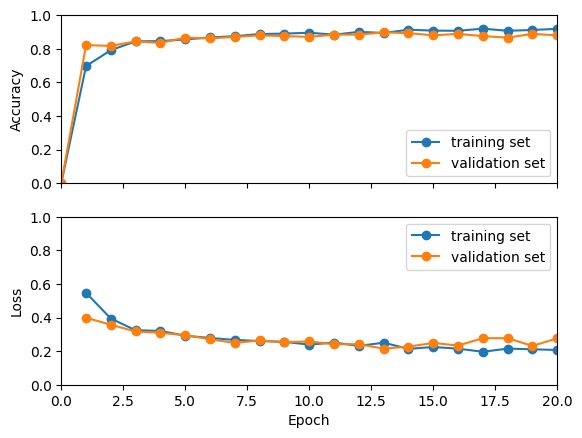

In [128]:
hyperparams_filename = "../models/01_15_24_case1_kxblpsda.hparams"
with open(hyperparams_filename, 'rb') as f:
    hyperparams = pickle.load(f)
    
history = hyperparams['history']
mutils.plot_history(history)

<a id='sec2'></a>
## Customizing model MobileNetV2: case2

<a id='sec2a'></a>
### Training using `train_dataset`
The previous section showed that **model1** (save in `../models/01_15_24_case1_kxblpsda.keras`) reaches ~88% of accuracy. We start from it and further fine tune it, training some of the layers that were previously frozen.

The fifth layer of **model1** (`starting_model.layers[4]`) corresponds to `mobilenetv2_1.00_224`. First, as seen in the snippet of `tensorflow_mototaxi.py::transfer_learning_case2()`, we select that 5th layer, unfreeze all its sublayers using `starting_model.layers[4].trainable = True`, and loop to freeze the first 126 sublayers. 

In [129]:
model1_filename = '../models/01_15_24_case1_kxblpsda.keras'
model1 = tfk.models.load_model(model1_filename)
model1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_27 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

Second, we train **model2** for 10 epochs in addition to the 20 used for training model1, `epochs=20 + num_epochs`. Thus, with `initial_epoch=20`, training model2 continues from the last state (20th epoch) of model1.

In [ ]:
#Snippet from tensorflow_mototaxi.py::transfer_learning_case2
def transfer_learning_case2(img_dir, hyperparams, starting_model):
    ...
    # Create model2
    model2 = starting_model
    # Unfreeze the 'model_without_top_layer' part of model1.
    aux_model = model2.layers[4]  # model2 has 4 layers. The 3rd is the mobilenetv2
    aux_model.trainable = True  # aux_model has 154 layers
    # From layer 127th to 154th will be allowed to train
    layer_cutoff = 126  # out of 154 layers will be frozen

    for i, layer in enumerate(aux_model.layers):
        if i < layer_cutoff:
            layer.trainable = False

    model2.compile(optimizer=tfk.optimizers.Adam(learning_rate=lr_initial),
                   loss=tfk.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy']
                   )

    history = model2.fit(train_dataset,
                         validation_data=val_dataset,
                         epochs=20 + num_epochs,
                         initial_epoch=20)

In [134]:
%run ../tensorflow_mototaxi.py case2

Training: Case2 (name=01_15_24_case2_kovgmlbs.keras, batch_size=32, num_epochs=10, learning rate: initial=0.0001)
Found 1116 files belonging to 2 classes.
Using 782 files for training.
Found 1116 files belonging to 2 classes.
Using 334 files for validation.
Epoch 21/30
25/25 [==============================] - 41s 1s/step - loss: 0.3503 - accuracy: 0.8414 - val_loss: 0.2544 - val_accuracy: 0.8884
Epoch 22/30
25/25 [==============================] - 35s 1s/step - loss: 0.1895 - accuracy: 0.9169 - val_loss: 0.2118 - val_accuracy: 0.8973
Epoch 23/30
25/25 [==============================] - 36s 1s/step - loss: 0.1426 - accuracy: 0.9386 - val_loss: 0.2448 - val_accuracy: 0.8884
Epoch 24/30
25/25 [==============================] - 35s 1s/step - loss: 0.1230 - accuracy: 0.9527 - val_loss: 0.2135 - val_accuracy: 0.8884
Epoch 25/30
25/25 [==============================] - 35s 1s/step - loss: 0.1159 - accuracy: 0.9540 - val_loss: 0.2464 - val_accuracy: 0.8839
Epoch 26/30
25/25 [==================

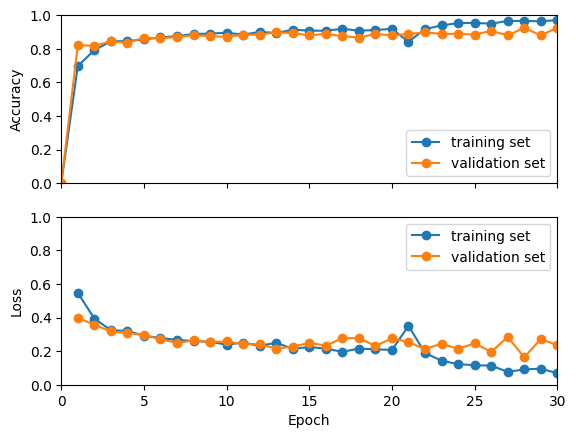

In [157]:
hyperparams_filename_model1 = "../models/01_15_24_case1_kxblpsda.hparams"
hyperparams_filename_model2 = "../models/01_15_24_case2_kovgmlbs.hparams"

with open(hyperparams_filename_model1, 'rb') as f:
    hyperparams_model1 = pickle.load(f)
    
with open(hyperparams_filename_model2, 'rb') as f:
    hyperparams_model2 = pickle.load(f)
    
history = hyperparams_model1['history']
history_model2 = hyperparams_model2['history']
history['loss'] += history_model2['loss']
history['accuracy'] += history_model2['accuracy']
history['val_loss'] += history_model2['val_loss']
history['val_accuracy'] += history_model2['val_accuracy']
mutils.plot_history(history)

### Validation using `test_dataset`

As seen above **model2** (saved in  '../models/01_15_24_case2_kovgmlbs.keras') reaches accuracy of ~92% using the validation `val_datatest`. Here, we further evaluate the model using `test_dataset`, which images have not seen before by the model. 

**model2** correctly predicts (mototaxi, no_mototaxi) for all 16 images chosen from `test_dataset`, shown below.


In [148]:
base_model_filename = '../models/01_15_24_case2_kovgmlbs.keras'
trained_model_2 = tfk.models.load_model(base_model_filename)

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = trained_model_2.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
yhats = tf.where(predictions < 0.5, 0, 1).numpy()
print(yhats)
print(label_batch)
print(image_batch.shape)


[1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1]
[1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1]
(16, 224, 224, 3)


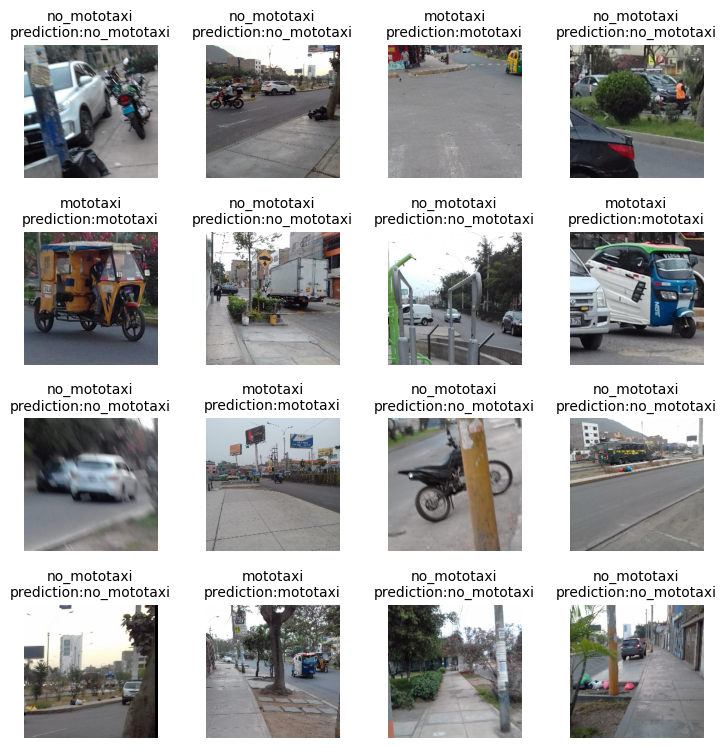

In [150]:
classes = train_dataset.class_names
num_images = len(predictions) 
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
fig.subplots_adjust(hspace=0.4)
import matplotlib.pyplot as plt
for i, ax in enumerate(axs.flat):
    plt.axes(ax)
    ax.axis('off')
    title = '{0:s}\nprediction:{1:s}'.format(classes[label_batch[i]], classes[yhats[i]])
    ax.set_title(title, fontsize=10)
    x = image_batch[i].astype("uint8")
    ax.imshow(x)